# **STANDARD NOTEBOOK TO GET RESULTS**

## 1. Clean the Data

In [1]:
import pandas as pd 
import process
import numpy as np 
# Jerome path : r'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DataBase.csv'
# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv(r'/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.fillna(0) # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

df_cleaned = df_cleaned.transpose() ## WE WANT COLUMNS TO BE VECTOR OF RETURN FOR A GIVEN TICKER

In [16]:
2512-250

2262

In [11]:
df_cleaned.iloc[2512:5279, :]

ticker,AA,ABM,ABT,ADI,ADM,ADX,AEE,AEG,AEM,AEP,...,XLI,XLK,XLP,XLU,XLV,XLY,XOM,XRX,YUM,ZTR
04/01/2010,0.010870,0.014212,0.004970,-0.003782,-0.000318,0.008819,-0.009679,0.010302,0.001068,-0.004569,...,0.008155,0.005602,0.008283,-0.006414,0.004439,0.003339,0.006238,0.010483,-0.000855,-0.002548
05/01/2010,-0.042482,-0.007128,-0.008296,-0.001580,0.002849,0.004880,-0.004331,-0.001452,0.003521,-0.012658,...,0.004938,-0.002578,-0.000375,-0.009076,-0.008272,0.003327,0.003319,0.001158,-0.004280,0.012837
06/01/2010,0.039669,0.002865,0.007020,-0.004742,-0.001267,0.004861,-0.005448,0.002924,0.006195,0.009503,...,0.004575,-0.011251,0.000375,0.006496,0.010172,0.001992,0.008174,-0.009302,-0.006603,-0.002541
07/01/2010,0.005433,0.016616,0.008434,-0.004779,-0.010194,0.004905,-0.009878,0.027478,-0.005698,0.011719,...,0.012583,-0.004794,-0.002996,-0.003247,0.007275,0.001976,-0.001432,0.008173,0.004042,-0.002548
08/01/2010,0.033456,0.004724,0.005282,0.009252,-0.009038,0.001940,-0.007745,0.016713,0.021620,0.012149,...,0.015504,0.007843,-0.001128,0.000326,-0.000315,0.003296,-0.002442,-0.001166,0.000576,0.007624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24/12/2020,-0.017156,-0.011338,0.008434,0.002495,0.000607,-0.000584,0.008141,0.000000,0.012527,0.007149,...,-0.001363,0.004893,0.004205,0.004913,0.002425,0.001141,-0.001201,-0.014509,0.002980,0.003446
28/12/2020,0.006315,0.009932,-0.010796,-0.011887,-0.002010,0.004078,0.001565,-0.005128,-0.027193,-0.005643,...,-0.005320,0.001380,0.004172,-0.000813,-0.002681,0.001630,0.001199,0.020396,0.011820,0.005705
29/12/2020,-0.004527,-0.024098,-0.001568,-0.010525,-0.008056,-0.004066,-0.003650,-0.012772,0.004506,-0.003320,...,-0.011128,-0.010187,-0.005503,-0.002600,0.000089,-0.003188,-0.018486,-0.019023,-0.001643,0.000000
30/12/2020,0.039099,-0.002646,-0.002303,0.010522,0.009259,0.001745,0.004819,0.000000,0.005840,0.005659,...,0.004663,-0.003997,-0.002237,0.004380,-0.002224,0.002430,0.006512,0.010099,0.001462,-0.002275


## 2. Run the code

Once the run is completed, you have: 
* the overall return -> overall return
* the PnL associated to the strategy
* the daily PnL associated to the strategy
* the Sharpe Ratio associated to the strategy

In [17]:
import warnings 
from PyFolioC import PyFolioC
warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

##################################################################### PARAMETERS #####################################################################
historical_data = df_cleaned
number_of_repetitions = 10
lookback_window = [2262,2512] ## so that the difference is a multiple of 5 --> year 2016
evaluation_window = 5
number_of_clusters = 38
cov_method = 'SPONGE'
sigma = 0.01
eta = 0.01

beta = 0.95
K = 4  # Number of fold for the cross validation
######################################################################################################################################################

##################################################################### PORTFOLIO ######################################################################
portfolio = PyFolioC(number_of_repetitions=number_of_repetitions, historical_data=historical_data, lookback_window=lookback_window, evaluation_window=evaluation_window, number_of_clusters=number_of_clusters, sigma=sigma, eta=eta, short_selling=True, cov_method=cov_method, beta=beta, number_folds=K)


## year 2008-2009 ==> 2007:2262 if evaluation_window == 2
## year 2008-2009 ==> 2007:2265 if evaluation_window == 5
## year 2012-2013 ==> 3016:3265
## year 2018-2019 ==> 4524:4774
## year 2016-2019 ==> 4021:4774
## year 2010-2020 ==> 2512:5279 (we go until 5277 to have a multiple of 5 for the difference)

In [18]:
overall_return, PnL, portfolio_value, daily_PnL = portfolio.sliding_window(553) ## 150 --> 3 years

step 1/553, portfolio value: 1.0025
step 2/553, portfolio value: 1.0026
step 3/553, portfolio value: 0.9979
step 4/553, portfolio value: 0.9943
step 5/553, portfolio value: 0.9890
step 6/553, portfolio value: 0.9904
step 7/553, portfolio value: nan
step 8/553, portfolio value: nan
step 9/553, portfolio value: nan
step 10/553, portfolio value: nan
step 11/553, portfolio value: nan
step 12/553, portfolio value: nan
step 13/553, portfolio value: nan
step 14/553, portfolio value: nan
step 15/553, portfolio value: nan
step 16/553, portfolio value: nan
step 17/553, portfolio value: nan
step 18/553, portfolio value: nan
step 19/553, portfolio value: nan
step 20/553, portfolio value: nan
step 21/553, portfolio value: nan
step 22/553, portfolio value: nan
step 23/553, portfolio value: nan
step 24/553, portfolio value: nan
step 25/553, portfolio value: nan
step 26/553, portfolio value: nan
step 27/553, portfolio value: nan
step 28/553, portfolio value: nan
step 29/553, portfolio value: nan
step 

KeyboardInterrupt: 

## 3. Save the results to csv files (APPLY THE CELLS ONLY ONCE AS IT CREATES 3 FILES !!)

In [69]:
year = '2016'
clustering_method = 'SPONGE_short_selling'

## process.save_to_csv(year=year, clustering_method=clustering_method)

df_daily = pd.DataFrame(daily_PnL, columns=['Daily PnL'])

df_daily.to_csv(f'daily_{year}_{clustering_method}_{evaluation_window}.csv', index=False)

df_PnL = pd.DataFrame(PnL, columns=['PnL'])

df_PnL.to_csv(f'PnL_{year}_{clustering_method}_{evaluation_window}.csv', index=False)

df_overall_return = pd.DataFrame(overall_return.values, columns=['Return'])

df_overall_return.to_csv(f'Overall_return_{year}_{clustering_method}_{evaluation_window}.csv', index=False)

## 4. Get SP500 data for comparison

In [18]:
len(overall_return)

50

In [31]:
start_date = '2008-01-01'
end_date = '2009-01-06'
year = '2008'
clustering_method = 'SPONGE_no_short_selling'

sp500_PnL = process.get_sp500_PnL(start_date, end_date)
print(len(sp500_PnL))
print(len(overall_return))

[*********************100%%**********************]  1 of 1 completed
255
255


## 5. Plot Portfolio Cumulative PnL vs SP500 Cumulative PnL

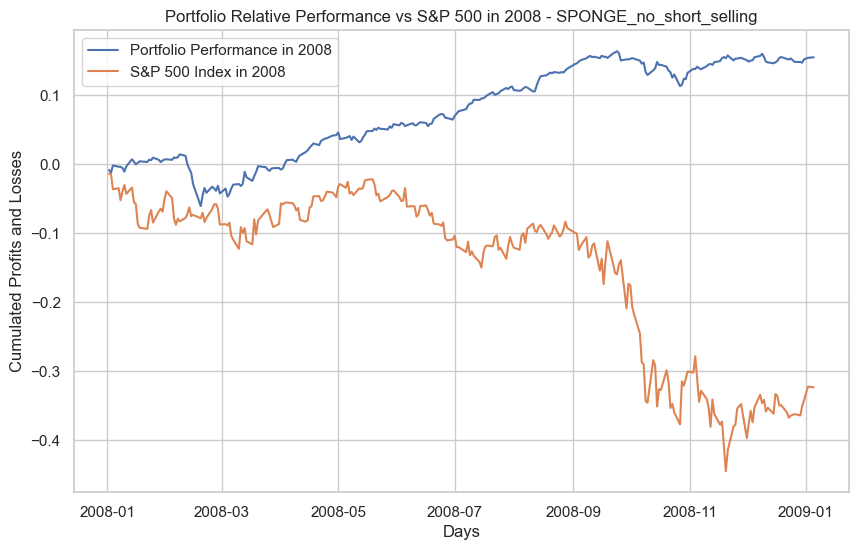

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the cumulative returns
portfolio_cumulative = pd.DataFrame(index = sp500_PnL.index, columns=[f'Portfolio Performance in {year}'], data=PnL)

# Set Seaborn style
sns.set(style="whitegrid")

# Plot the relative performance using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=portfolio_cumulative)
sns.lineplot(data=sp500_PnL.cumsum(), label=f'S&P 500 Index in {year}')
plt.xlabel('Days')
plt.ylabel('Cumulated Profits and Losses')
plt.title(f'Portfolio Relative Performance vs S&P 500 in {year} - {clustering_method}')
plt.legend()
plt.show()

# 6. Plot portfolio value alone

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Création de l'axe des abscisses (nombre de jours)

portfolio_value = pd.DataFrame(index = sp500_PnL.index, columns=[f'Portfolio Value in {year}'], data=portfolio_value)

# Configuration de seaborn pour un style agréable
sns.set(style="whitegrid")

# Tracer la PnL cumulative avec seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(portfolio_value, color='blue')

# Ajouter des titres et des légendes
plt.title(f'Portfolio Value of Time for an Initial Investment of $1 in {year} - {clustering_method}')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')

# Afficher le graphique
plt.show()

ValueError: Shape of passed values is (51, 1), indices imply (251, 1)

# 7. Barplot Daily PnL vs SP500

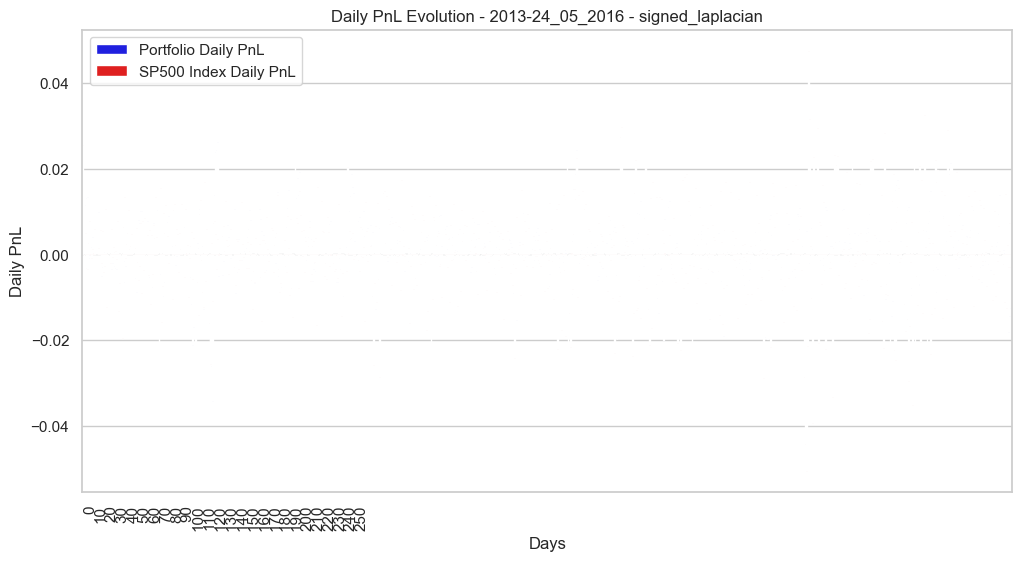

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Création de l'axe des abscisses (nombre de jours)
days = np.arange(1, len(daily_PnL) + 1)

# Configuration de seaborn pour un style agréable
sns.set(style="whitegrid")

# Tracer l'évolution quotidienne de la PnL sous forme de diagramme à barres avec seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=days, y=daily_PnL, color='blue', width=0.8, label='Portfolio Daily PnL')  # Ajustez la largeur ici
ax = sns.barplot(x=days, y=sp500_PnL, color='red', width=0.8, label='SP500 Index Daily PnL')

# Rotation des étiquettes de l'axe des abscisses de 45 degrés avec un ajustement
ax.set_xticks(np.arange(0,251,10))
ax.set_xticklabels(ax.get_xticks(), rotation=90, ha='right', rotation_mode='anchor')

# Ajouter des titres et des légendes
plt.title(f'Daily PnL Evolution - {year} - {clustering_method}')
plt.xlabel('Days')
plt.ylabel('Daily PnL')
plt.legend()

# Afficher le graphique
plt.show()

# 8. Plot everything (SPONGE vs Signed Laplacian vs SP500)

In [73]:
sp500_PnL.iloc[:-2]

Date
2014-01-02   -0.007520
2014-01-03   -0.000997
2014-01-06   -0.003001
2014-01-07    0.004968
2014-01-08   -0.000222
                ...   
2014-12-22    0.005017
2014-12-23    0.000374
2014-12-24   -0.000742
2014-12-26    0.002422
2014-12-29    0.001593
Name: Daily PnL, Length: 250, dtype: float64

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

PnL_SPONGE_5 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2016/PnL_2013-24_05_2016_SPONGE_5_2.csv')
PnL_SPONGE_1 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2018/PnL_2018_SPONGE_1.csv')
PnL_SPONGE_sym_5 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2016/PnL_2013-24_05_2016_SPONGE_sym_5_2.csv')
PnL_SL_5 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2016/PnL_2013-24_05_2016_signed_laplacian_5_2.csv')

#PnL_SPONGE_5_2 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2019/PnL_2019_SPONGE_5_2.csv')
#PnL_SPONGE_sym_5_2 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2019/PnL_2019_SPONGE_sym_5_2.csv')
#PnL_SL_5_2 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2019/PnL_2019_signed_laplacian_5_2.csv')

# Calculate the cumulative returns
portfolio_cumulative_SL_5 = pd.DataFrame(index=sp500_PnL.index, columns=[f'Signed Laplacian Portfolio Performance in {year}'], data=PnL_SL_5.values)
portfolio_cumulative_SPONGE_5 = pd.DataFrame(index=sp500_PnL.index, columns=[f'SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_5.values)
portfolio_cumulative_SPONGE_1 = pd.DataFrame(index=sp500_PnL.index, columns=[f'SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_1.values)
portfolio_cumulative_SPONGE_sym_5 = pd.DataFrame(index=sp500_PnL.index, columns=[f'Symmetric SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_sym_5.values)

# portfolio_cumulative_SL_5_2 = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=[f'Signed Laplacian Portfolio Performance in {year}'], data=PnL_SL_5_2.values)
# portfolio_cumulative_SPONGE_5_2 = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=[f'SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_5_2.values)
# portfolio_cumulative_SPONGE_sym_5_2 = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=[f'Symmetric SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_sym_5_2.values)

# Combine dataframes for seaborn plotting
## combined_df = pd.concat([portfolio_cumulative_SL_5, portfolio_cumulative_SL_5_2, portfolio_cumulative_SPONGE_5, portfolio_cumulative_SPONGE_5_2, portfolio_cumulative_SPONGE_sym_5, portfolio_cumulative_SPONGE_sym_5_2, sp500_PnL.iloc[:-1].cumsum()], axis=1)
combined_df = pd.concat([portfolio_cumulative_SL_5, portfolio_cumulative_SPONGE_5, portfolio_cumulative_SPONGE_sym_5, sp500_PnL.iloc[:-2].cumsum()], axis=1)
combined_df.columns = [f'Signed Laplacian - Evaluation window {evaluation_window}', f'SPONGE - Evaluation window {evaluation_window}', f'SPONGE_sym - Evaluation window {evaluation_window}', f'S&P 500 Index in {year}']

# Set Seaborn style
sns.set(style="darkgrid")

# Plot the relative performance using Seaborn
plt.figure(figsize=(15, 8))
sns.lineplot(data=combined_df, palette=['blue', 'red', 'orange', 'green'], alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Cumulated Profits and Losses')
plt.title(f'Portfolio Relative Performance vs S&P 500 in {year}')
plt.legend()
plt.show()

ValueError: Shape of passed values is (250, 1), indices imply (855, 1)